# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
!pip install xlrd >= 1.0.0

In [3]:
# TODO
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',
                   index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [4]:
 # show if there are missing values and columns data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 309_1 to J3295_15
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1077 non-null   float64
 1   ITSN1_N          1077 non-null   float64
 2   BDNF_N           1077 non-null   float64
 3   NR1_N            1077 non-null   float64
 4   NR2A_N           1077 non-null   float64
 5   pAKT_N           1077 non-null   float64
 6   pBRAF_N          1077 non-null   float64
 7   pCAMKII_N        1077 non-null   float64
 8   pCREB_N          1077 non-null   float64
 9   pELK_N           1077 non-null   float64
 10  pERK_N           1077 non-null   float64
 11  pJNK_N           1077 non-null   float64
 12  PKCA_N           1077 non-null   float64
 13  pMEK_N           1077 non-null   float64
 14  pNR1_N           1077 non-null   float64
 15  pNR2A_N          1077 non-null   float64
 16  pNR2B_N          1077 non-null   float64
 17  pPKCAB_N   

In [5]:
# TODO
warnings.filterwarnings('ignore')

df1 = df.fillna(df.mean())
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 309_1 to J3295_15
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1080 non-null   float64
 1   ITSN1_N          1080 non-null   float64
 2   BDNF_N           1080 non-null   float64
 3   NR1_N            1080 non-null   float64
 4   NR2A_N           1080 non-null   float64
 5   pAKT_N           1080 non-null   float64
 6   pBRAF_N          1080 non-null   float64
 7   pCAMKII_N        1080 non-null   float64
 8   pCREB_N          1080 non-null   float64
 9   pELK_N           1080 non-null   float64
 10  pERK_N           1080 non-null   float64
 11  pJNK_N           1080 non-null   float64
 12  PKCA_N           1080 non-null   float64
 13  pMEK_N           1080 non-null   float64
 14  pNR1_N           1080 non-null   float64
 15  pNR2A_N          1080 non-null   float64
 16  pNR2B_N          1080 non-null   float64
 17  pPKCAB_N   

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [6]:
# TODO
y = df1['Genotype'].values
# extract the encoding of categorical data
y_class, y = np.unique(y, return_inverse=True)
len(y)

1080

As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [7]:
# TODO
xnames = df1.columns[0: -4]
X = df1.iloc[:, 0:-4]
X.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.205604,0.129954,0.134762,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730


Split the data into training and test with 30% allocated for test.  You can use the train

In [8]:
from sklearn.model_selection import train_test_split

# TODO:
Xtr, Xts, ytr, yts = train_test_split(X, y, random_state=1, test_size=0.3)

Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`. 

In [9]:
from sklearn.preprocessing import StandardScaler

# TODO
scaler = StandardScaler()
Xtr1 = scaler.fit_transform(Xtr.values)
Xts1 = scaler.transform(Xts.values)

Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`. 

In [10]:
# TODO
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, solver='liblinear')
logreg = logreg.fit(Xtr1, ytr)

Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [11]:
# TODO
from sklearn.metrics import accuracy_score
yhat = logreg.predict(Xts1)
accuracy = accuracy_score(yts, yhat)
round(accuracy*100, 2)

94.44

## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

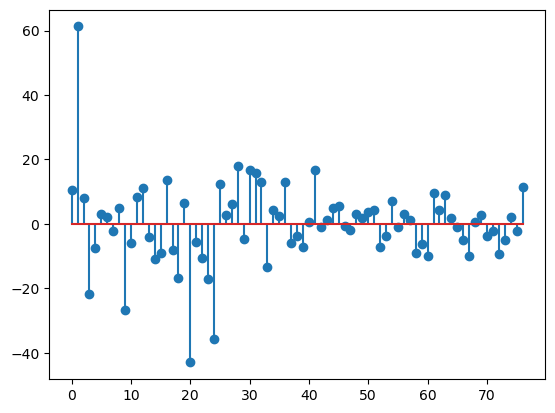

In [12]:
# TODO
warnings.filterwarnings('ignore')

W = logreg.coef_.reshape(-1,)
plt.stem(W, use_line_collection=True)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [13]:
# TODO
W_sorted = sorted(abs(W))
max_W = W_sorted[-2:]
# get the i of two maximum weights
i = []
i.append(np.where(abs(W) == max_W[1])[0][0]) # the i of the largest gene 
i.append(np.where(abs(W) == max_W[0])[0][0]) # the i of the second largest gene

# get two genes with highest magnitudes
highest_genes = xnames[i]
highest_genes

Index(['ITSN1_N', 'BRAF_N'], dtype='object')

## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [14]:
# a funiction returns a different logistic regression model for each fold
def logistic_with_kf(kf, indices):
    """
    this function train logistic regression models on data splitted into 10 datasets and returns the classification
    metrics the evaluate the models.
    input:
        kf: the splitter to folds
        indices: indices to be splitted for filtering
    output:
        tuple(class_metrics, list_confus): a data frame of classification metrics for each model and 
        confusion matrix for each model and the list of all accuracies over each model
    """
    list_metrics = []
    list_confus = []
    list_accurr = []
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    for trainI, testI in kf.split(indices): # extract indices of each fold for train and test
        model = LogisticRegression()
        # fitting the model on  training data of each fold
        model = model.fit(X_scaled[trainI], y[trainI])  
        y_pred = model.predict(X_scaled[testI])
        # get classification metrics of each model
        metrics = precision_recall_fscore_support(y[testI], y_pred) 
        # get the error rate using  (1 - accuracy_score function output)
        error_rate = 1 - accuracy_score(y[testI], y_pred) 
        list_metrics.append([metrics[0][1], metrics[1][1], metrics[2][1], error_rate])
        # append the confusion matrix for each model with normalized rows
        list_confus.append(confusion_matrix(y[testI], y_pred, normalize='true'))
        # append the accurrecy for each model
        list_accurr.append(accuracy_score(y[testI], y_pred))
    # return a data frame to store the metrics
    class_metrics = pd.DataFrame(list_metrics, columns=['precision', 'recall', 'f-1 score', 'error rate'])    
    return class_metrics, list_confus, list_accurr
    

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
warnings.filterwarnings('ignore') 

nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

# TODO
class_metrics = logistic_with_kf(kf, df1.index)[0]
#get the average over 10 models
class_metrics.mean() 

    


precision     0.980270
recall        0.960885
f-1 score     0.970324
error rate    0.027778
dtype: float64

## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [16]:
# TODO
y = np.unique(df1['class'], return_inverse=True)[1]
y

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [17]:
from sklearn.model_selection import KFold

# TODO
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
# get the confusion matrices and accuracies
C, accurr = logistic_with_kf(kf, df1.index)[1:] 





In [18]:
print(np.array_str(np.array(C), precision=4, suppress_small=True))

[[[1.     0.     0.     0.     0.     0.     0.     0.    ]
  [0.     0.9    0.     0.     0.     0.1    0.     0.    ]
  [0.     0.     1.     0.     0.     0.     0.     0.    ]
  [0.     0.     0.     1.     0.     0.     0.     0.    ]
  [0.     0.     0.     0.     1.     0.     0.     0.    ]
  [0.     0.     0.     0.     0.     1.     0.     0.    ]
  [0.     0.     0.     0.     0.     0.     1.     0.    ]
  [0.     0.     0.     0.     0.     0.     0.     1.    ]]

 [[1.     0.     0.     0.     0.     0.     0.     0.    ]
  [0.     1.     0.     0.     0.     0.     0.     0.    ]
  [0.     0.     1.     0.     0.     0.     0.     0.    ]
  [0.     0.     0.     1.     0.     0.     0.     0.    ]
  [0.     0.     0.     0.     1.     0.     0.     0.    ]
  [0.     0.     0.     0.     0.     1.     0.     0.    ]
  [0.     0.     0.     0.     0.     0.     1.     0.    ]
  [0.     0.     0.     0.     0.     0.     0.     1.    ]]

 [[1.     0.     0.     0.     0.   

In [19]:
import math
print('The mean over all the accurracies is : {}\n The SE over the all accurracies is : {}'
      .format(round(np.mean(accurr), 2), 
      round(np.std(accurr)/ math.sqrt(nfold), 5)
             )
     )

The mean over all the accurracies is : 0.99
 The SE over the all accurracies is : 0.00333


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

In [20]:
X.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.205604,0.129954,0.134762,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730


In [21]:
y

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [22]:
# TODO
Xtr, Xts, ytr, yts = train_test_split(X, y, random_state=1, test_size=0.3)
model = LogisticRegression()
model = model.fit(Xtr, ytr)

weights = model.coef_

In [23]:
weights

array([[ 2.54708149e-01, -8.66100912e-01,  2.30516384e-01,
         2.69683748e-01,  1.17187686e+00,  2.61250110e-01,
         2.54288733e-01, -6.94854774e-01, -4.23234141e-01,
        -7.52829827e-01,  1.76254229e+00,  8.01765771e-01,
         4.88498819e-01,  2.25606042e-01,  7.65414767e-02,
        -5.51517888e-01, -1.35522636e+00,  3.79031886e-01,
         5.02934652e-01,  2.81980582e-01,  7.51606037e-01,
        -1.42547729e-01, -1.02777130e-01, -4.58387689e-01,
         1.18264830e+00,  1.47037497e+00,  4.08085375e-01,
        -2.53840960e-01,  5.86914777e-01, -3.66561384e-02,
        -8.94526570e-01, -1.41518423e+00, -2.19197010e+00,
         8.74576811e-01,  9.56962014e-01,  4.63059739e-01,
        -6.46167273e-01,  9.51779741e-02,  8.72928198e-01,
         2.86691746e-01,  3.82433129e-02, -8.52304236e-01,
         3.67321944e-01, -4.03320416e-01, -1.18154385e+00,
        -2.43989344e-01, -7.30193236e-02, -2.00863015e-01,
        -2.37528020e-01,  3.89118418e-02, -6.05366875e-0

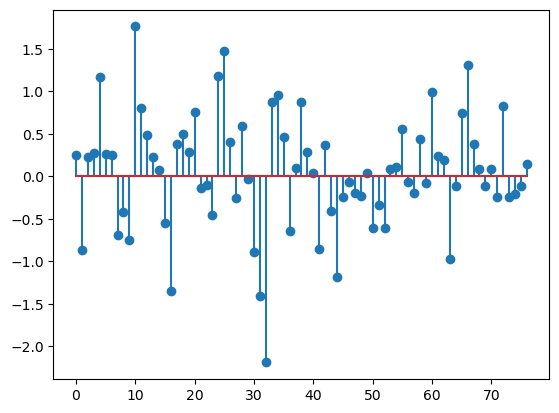

In [24]:
W = weights[0].reshape(-1,)
plt.stem(W, use_line_collection=True);

## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

In [25]:
# TODO